## This is the Ekman composite Figure + the time series

### Prepare Ekman Composite 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40467/status,
Dashboard: /proxy/40467/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34127,Workers: 7
Dashboard: /proxy/40467/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:33139,Total threads: 4
Dashboard: /proxy/39859/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:38983,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [4]:
lon_slice  = slice(-256, -246) 
lat_slice  = slice(-67, -64)


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [5]:
#pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-256, -246) 
lat_slice  = slice(-67, -64)


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

In [6]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

In [7]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [8]:
# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# compute curl:
curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
curl_tauf_con = curl_tauf_con.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.
ekman_con = curl_tauf_con/rho0*s_day


### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [14]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [15]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

### Roll ekman in time, for 6 months. 

In [16]:
ekman_roll=ekman_con
ekman_roll=ekman_roll.shift(time=-2).dropna(dim='time')


In [19]:
## because bt_id has high indexes we need to get rid off them. This data is no longer existent if we shift ekman back 8, 9,10 months / ekman_roll now has time 727
bt_6=bt_id[:-2]

## because bt_id has high indexes we need to get rid off them. This data is no longer existent if we shift ekman back 6, 6a and 7 months / ekman_roll now has time 727
#bt_6=bt_id[:-3]

## because bt_id has high indexes we need to get rid off them. This data is no longer existent if we shift ekman back 4 months / ekman_roll now has time 727
#bt_6=bt_id[:-1]

### creating the averages for peaks and lows

In [20]:
#full mean
ekman_con_avg = ekman_roll.mean('time')
ekman_con_avg = ekman_con_avg.load()

#mean of all high peaks together
ekman_high_avg=ekman_roll[top_id].mean('time')
ekman_high_avg = ekman_high_avg.load()

#mean of all low peaks together
ekman_low_avg=ekman_roll[bt_6].mean('time')
ekman_low_avg = ekman_low_avg.load()

## PLOT COMPOSITES FOR EKMAN

In [21]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

#### lag 0
#### lag 2
#### lag 4
#### lag 6

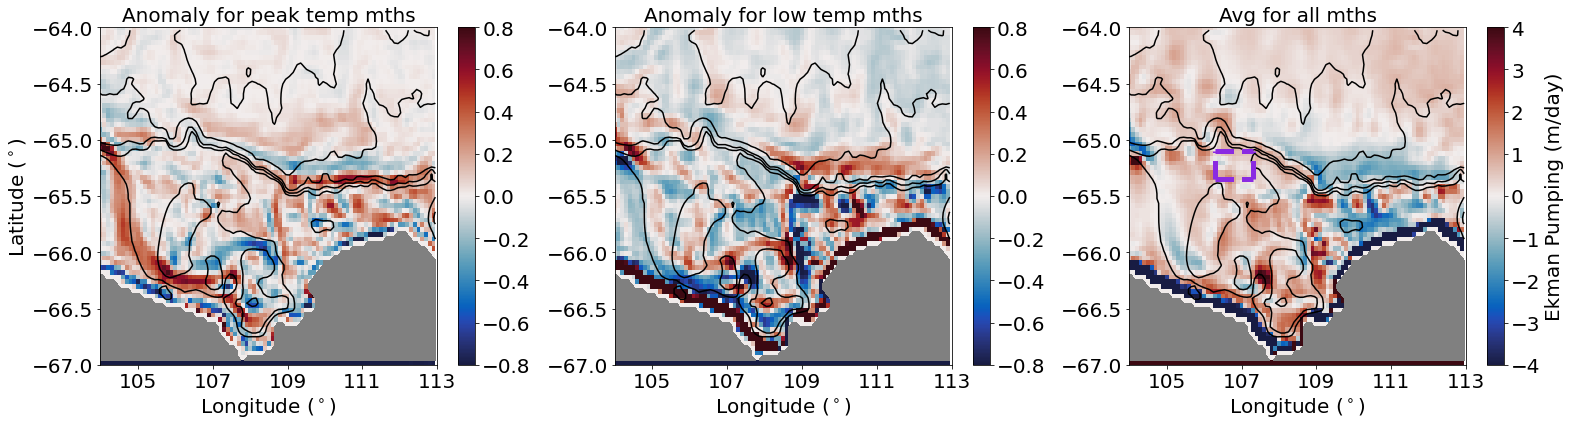

In [24]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = ekman_high_avg-ekman_con_avg;
t_low = ekman_low_avg-ekman_con_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
plt.title('Anomaly for peak temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,1000],colors='darkorange',linewidth=1)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.8,vmax=.8)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='magenta',linestyle='--',linewidth=4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for low temp mths',fontsize=fontsize)
#plt.title('Anomaly for falling Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000],colors='magenta',linewidth=2.5)
#plt.plot([-250,-247],[-65,-65],'--')
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(ekman_con_avg.xu_ocean,ekman_con_avg.yu_ocean,
                        ekman_con_avg, cmap = cmocean.balance, 
                        vmin=-4,vmax=4)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=5)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=5)
#
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman Pumping (m/day)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/fig6a_composite_ekman.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')



### LOAD SPECIAL CONTOURS

In [48]:
# cut the data BOX 1
lon_slice  = slice(-253, -251.5) #isopycnal contour
lat_slice  = slice(-67, -63)

# topography data:
ht2 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht2 = ht2.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask2 = np.squeeze(ht2.values)*0
land_mask2[np.isnan(land_mask2)] = 1
land_mask2 = np.where(land_mask2==1,land_mask2,np.nan)

fontsize=16

In [49]:
# cut the data BOX 1
lon_slice  = slice(-251, -246) #ekman contour
lat_slice  = slice(-67, -63)

# topography data:
ht3 = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht3 = ht3.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask3 = np.squeeze(ht2.values)*0
land_mask3[np.isnan(land_mask3)] = 1
land_mask3 = np.where(land_mask3==1,land_mask3,np.nan)

fontsize=16


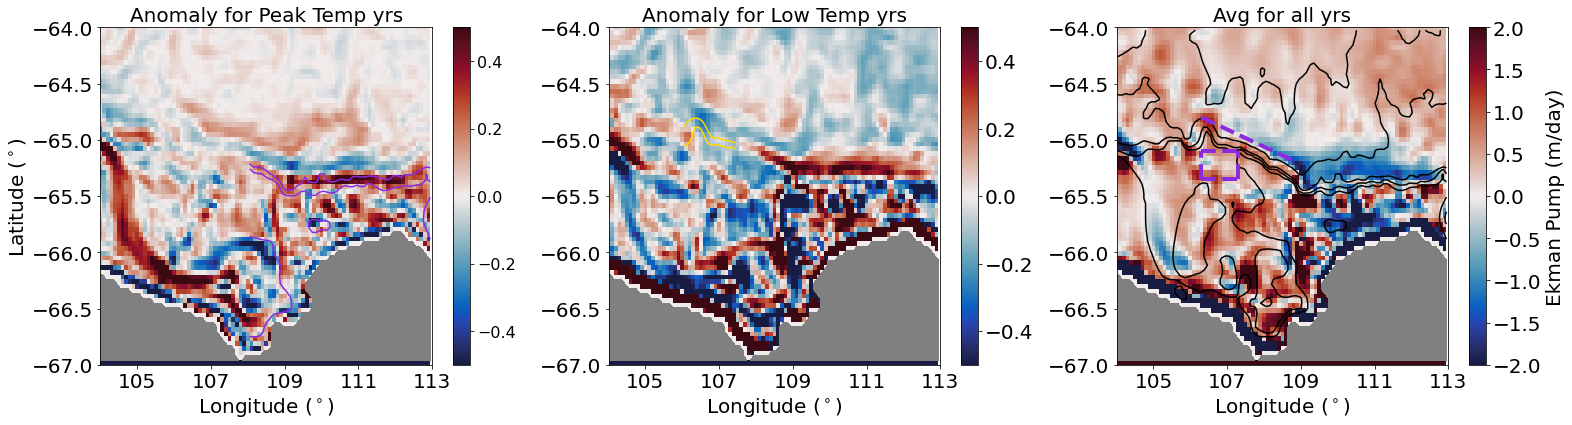

In [50]:
### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = ekman_high_avg-ekman_con_avg;
t_low = ekman_low_avg-ekman_con_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
plt.title('Anomaly for Peak Temp yrs',fontsize=fontsize)
        #plot contours
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contour(ht3.xt_ocean,ht3.yt_ocean,ht3,levels=[500,1000],colors='blueviolet',linewidth=1)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.tick_params(labelsize=16)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.5,vmax=.5)
#plt.plot([-252.1,-250.1],[-64.8,-65.1],color='magenta',linestyle='--',linewidth=4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for Low Temp yrs',fontsize=fontsize)
#plt.title('Anomaly for falling Temp yrs',fontsize=fontsize)
        #plot contours
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=1)
plt.contour(ht2.xt_ocean,ht2.yt_ocean,ht2,levels=[1000,2000],colors='gold',linewidth=2.5)
#plt.plot([-250,-247],[-65,-65],'--')
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(ekman_con_avg.xu_ocean,ekman_con_avg.yu_ocean,
                        ekman_con_avg, cmap = cmocean.balance, 
                        vmin=-2,vmax=2)
plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=4)
#
plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ekman Pump (m/day)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/fig6a_composite_ekman_specialcontour.eps'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [51]:
ekman_high_avg.mean()

<xarray.DataArray ()>
array(-0.00537937)

In [52]:
ekman_low_avg.mean()

<xarray.DataArray ()>
array(-0.00507429)

### CALCULATIONS

In [53]:
# cut the data BOX 1
lon_slice  = slice(-255, -247.5)
lat_slice  = slice(-67.5, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

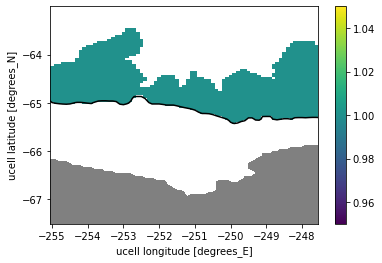

In [54]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U10003000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [55]:
#apply the mask of 1000-3000 MEAN
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.mean('xu_ocean').mean('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.mean('xu_ocean').mean('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-0.01035871975510997
-0.019610976558044082


In [56]:
#apply the mask of 1000-3000 SUM
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.sum('xu_ocean').sum('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.sum('xu_ocean').sum('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

190.89874845174765
162.40097962669782


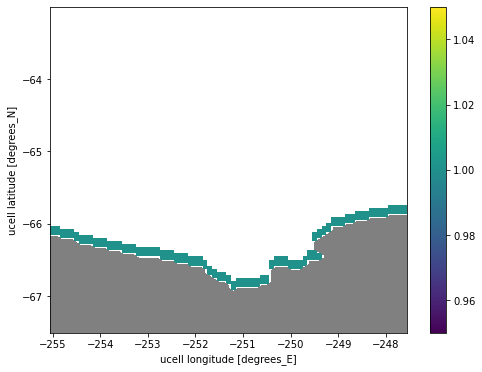

In [57]:
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U0m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=1)] = np.nan
shelf_mask = shelf_mask+0
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

plt.figure(figsize=(8,6))
region_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[700,1000,2000,3000],colors='k')
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [58]:
#apply the mask of shelf MEAN
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.mean('xu_ocean').mean('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.mean('xu_ocean').mean('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-9.386173491989227
-7.807615922317264


In [59]:
#apply the mask of shelf SUM
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.sum('xu_ocean').sum('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.sum('xu_ocean').sum('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-2055.289934775079
-1684.7458704362832


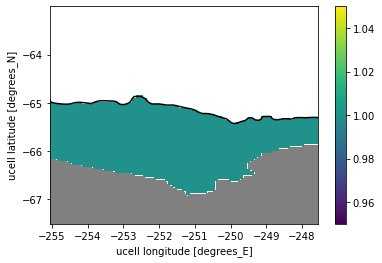

In [60]:

# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U10003000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=1)] = np.nan
shelf_mask = shelf_mask+0
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
i=plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

In [61]:
#apply the mask of shelf MEAN
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.mean('xu_ocean').mean('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.mean('xu_ocean').mean('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-1.6313375920091686
-1.433889954485904


In [62]:
#apply the mask of shelf SUM
ekman_high_shelf = ekman_high_avg*region_mask
ekman_high_shelf = ekman_high_shelf.where(ekman_high_shelf!=0)
ekman_high_shelf=ekman_high_shelf.sum('xu_ocean').sum('yu_ocean')

ekman_low_shelf = ekman_low_avg*region_mask
ekman_low_shelf = ekman_low_shelf.where(ekman_low_avg!=0)
ekman_low_shelf=ekman_low_shelf.sum('xu_ocean').sum('yu_ocean')


print(np.nanmax(ekman_high_shelf))
print(np.nanmax(ekman_low_shelf))

-1303.3311574777367
-1202.3038168959702
